# Setup

In [1]:
pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [6]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-14 15:30:52.736204: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 15:30:53.290160: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-14 15:30:53.290213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30967 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0


In [7]:
config = json.load(open("./configs/mnn_btl_w2v_pretrained_amazon.json"))

# Loading data

In [8]:
from data_loader.abo import ABO

In [9]:
data = ABO(path=config["data"]["path"],
           download=True,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=False,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'path', 'product_type', 'label']]
data

abo-listings.tar already exists.
abo-images-small.tar already exists.
Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,path,product_type,label
0,mobile coverb07tf1bkqyamazon brand - solimo de...,42/423d10f4.jpg,CELLULAR_PHONE_CASE,1
1,back coverb0856bygtgamazon brand - solimo desi...,9c/9cf1dd23.jpg,CELLULAR_PHONE_CASE,1
2,mobile coverb07t9tn394amazon brand - solimo de...,30/30126ff7.jpg,CELLULAR_PHONE_CASE,1
3,mobile coverb07sp4hfwfamazon brand - solimo de...,1b/1bc5782f.jpg,CELLULAR_PHONE_CASE,0
4,mobile coverb075ylrjlpamazon brand: find drive...,a8/a8746f69.jpg,CELLULAR_PHONE_CASE,0
...,...,...,...,...
168173,mobile coverb07tqh6zlfamazon brand - solimo de...,52/520ada11.jpg,CELLULAR_PHONE_CASE,0
168174,mobile coverb081hnqj2hamazon brand - solimo de...,7a/7a349abb.jpg,CELLULAR_PHONE_CASE,1
168175,mobile coverb081hmx7msamazon brand - solimo de...,37/3751f5bb.jpg,CELLULAR_PHONE_CASE,0
168176,amazon brand - solimob07xvpttvfamazon brand - ...,d9/d9a98067.jpg,CELLULAR_PHONE_CASE,1


In [10]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

https://huggingface.co/fse/word2vec-google-news-300

Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' 

In [11]:
from gensim.models import KeyedVectors

In [12]:
w2v_pretrained_model = KeyedVectors.load(f'./word2vec-google-news-300/word2vec-google-news-300.model')

In [13]:
w2v_vectors = np.load(f'./word2vec-google-news-300/word2vec-google-news-300.model.vectors.npy', allow_pickle=True)

In [14]:
w2v_vectors.shape

(3000000, 300)

In [15]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=None, output_sequence_length=300)

vectorizer.adapt(text)

In [16]:
text = vectorizer(text).numpy()
text.shape

(168178, 300)

In [17]:
voc = vectorizer.get_vocabulary()
voc[:10]

['',
 '[UNK]',
 'mobile',
 'back',
 'brand',
 'for',
 'solimo',
 'cover',
 'case',
 'designer']

In [18]:
word_index = dict(zip(voc, range(len(voc))))

In [19]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if w2v_pretrained_model.has_index_for(word):
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = w2v_pretrained_model.get_vector(word, norm=True)
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8965 words (155172 misses)


W2V Google Embedding only converts less than 10% of data!

# Image processing

## Load image model

In [20]:
from utils.img_processing import load_img_model, create_embeddings_from

In [21]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [ ]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "images/small"),
                             batch_size=1024)

In [ ]:
img.shape

# Save embeddings

In [22]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/w2v_pretrained/{img_model.name}")

In [ ]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [23]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,surface cleanerb07zkpz5m9amazon brand - presto...,11/11fcff6f.jpg,HEALTH_PERSONAL_CARE,1
1,mobile coverb07tcwt6qzamazon brand - solimo de...,6d/6d467c22.jpg,CELLULAR_PHONE_CASE,1
2,clear caseb08569tz7mamazon brand rivet geomet...,ae/ae7772de.jpg,GROCERY,0
3,grocery & gourmet food beverages bottled bever...,97/97abbdae.jpg,JUICE_AND_JUICE_DRINK,1
4,back coverb08569h3s9amazon brand - solimo desi...,18/18096140.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
168180,mobile coverb08569ppwramazonbasics metal monit...,17/17f2fb25.jpg,SHOES,0
168181,not applicableb07wny6fhfamazon essentials wome...,db/db20fd35.jpg,SHOES,1
168182,mobile coverb07th14222strathwood chaise lounge...,6d/6dc131cd.jpg,CELLULAR_PHONE_CASE,0
168183,stuffingb07jlz7qc7amazon brand rivet contempo...,ac/acec2689.jpg,PILLOW,1


In [24]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(168185, 576)

In [25]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(168185, 300)

# Train-Test Split

## Split into ground truth/false samples

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [26]:
ground_truth = data[data["label"] == 1]
false_samples = data[data["label"] == 0]
data = ground_truth
data

,description,path,product_type,label
0,surface cleanerb07zkpz5m9amazon brand - presto...,11/11fcff6f.jpg,HEALTH_PERSONAL_CARE,1
1,mobile coverb07tcwt6qzamazon brand - solimo de...,6d/6d467c22.jpg,CELLULAR_PHONE_CASE,1
3,grocery & gourmet food beverages bottled bever...,97/97abbdae.jpg,JUICE_AND_JUICE_DRINK,1
4,back coverb08569h3s9amazon brand - solimo desi...,18/18096140.jpg,CELLULAR_PHONE_CASE,1
7,mobile coverb07t22xb8damazon brand - solimo de...,37/3772efa6.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
168176,cellphonecoverb08569yts4amazon brand - solimo ...,11/11e67bd1.jpg,CELLULAR_PHONE_CASE,1
168177,cellphonecoverb0853xkskvamazon brand - solimo ...,d7/d79173cf.jpg,CELLULAR_PHONE_CASE,1
168181,not applicableb07wny6fhfamazon essentials wome...,db/db20fd35.jpg,SHOES,1
168183,stuffingb07jlz7qc7amazon brand rivet contempo...,ac/acec2689.jpg,PILLOW,1


In [27]:
false_samples

,description,path,product_type,label
2,clear caseb08569tz7mamazon brand rivet geomet...,ae/ae7772de.jpg,GROCERY,0
5,mobile coverb07t8114tkchoco-cran cherry trail ...,ae/ae2d64e3.jpg,ACCESSORY,0
6,mobile coverb0853x7fbhamazon brand - solimo de...,33/330b137e.jpg,CELLULAR_PHONE_CASE,0
9,"mobile coverb07qkgcvf4whole foods market, esse...",70/7003df63.jpg,CELLULAR_PHONE_CASE,0
11,apple iphone xr mobile back case cover transpa...,16/165be3da.jpg,CELLULAR_PHONE_CASE,0
...,...,...,...,...
168174,back coverb07th2zwqk365 everyday value organic...,bb/bb89c89d.jpg,SHOES,0
168178,back coverb07th3zyr3amazon brand - solimo desi...,ac/ac1f2d24.jpg,SHOES,0
168179,mobile coverb07tg4rtzdamazon brand - symbol me...,4b/4b8de49c.jpg,CELLULAR_PHONE_CASE,0
168180,mobile coverb08569ppwramazonbasics metal monit...,17/17f2fb25.jpg,SHOES,0


In [28]:
img_false = img[false_samples.index]
text_false = text[false_samples.index]

In [29]:
img = img[data.index]
text = text[data.index]

In [30]:
data = data.reset_index(drop=True)
false_samples = false_samples.reset_index(drop=True)

In [31]:
img.shape

(87380, 576)

In [32]:
img_false.shape

(80805, 576)

## Ground truth

In [33]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [34]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
train, test, product_types_train, product_types_test = train_test_split(
    data,
    product_types,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [37]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

## False samples

In [38]:
false_samples["product_type_count"] = false_samples.groupby(
    ["product_type"])["product_type"].transform("count")

false_samples = false_samples[false_samples["product_type_count"] > config["data"]["cls"]]

In [39]:
# Update both columns
product_types_false = false_samples[["product_type"]]

labels_false = false_samples[["label"]]

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
train_false, test_false, product_types_train_false, product_types_test_false = train_test_split(
    false_samples,
    product_types_false,
    stratify=product_types_false,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [42]:
img_train_false = img_false[train_false.index]
img_test_false = img_false[test_false.index]

text_train_false = text_false[train_false.index]
text_test_false = text_false[test_false.index]

# Build MNN-BTL Model

In [47]:
from utils.metrics import create_metrics

In [48]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": embedding_dim,
    "img_fc_layers": config["model"]["img_fc_layers"],
    "txt_fc_layers": config["model"]["txt_fc_layers"],
    "extended": False,
}

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from models.mnn_em import _CNNBranch
from models.addons.tensorflow_addons.losses import triplet_multimodal


class MNNBTLWord2VecPretrained(object):
    def __init__(self, head_config, learning_rate, name="MNN_BTL"):
        self.head_config = head_config
        self.learning_rate = learning_rate
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Text Input
        img_features = Input(shape=(self.head_config["img_input_size"]),
                             name="Image_Input_Head_Outer")

        img_cnn = _CNNBranch(self.head_config["img_input_size"],
                             self.head_config["img_fc_layers"], self.head_config["extended"], True, name="Image")

        # Image Input
        text_features = Input(shape=(self.head_config["txt_input_size"]), dtype=tf.int64, name="Text_Input_Head_Outer")

        embedding_layer = Embedding(
            num_tokens,
            self.head_config["txt_input_size"],
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False,
        )

        x = embedding_layer(text_features)

        x = Flatten()(x)

        text_branch = _CNNBranch(x.shape[1],
                                 self.head_config["txt_fc_layers"], self.head_config["extended"], True, name="Text")

        output_text_branch = text_branch.model(x)

        text_cnn = Model(inputs=text_features,
                         outputs=output_text_branch, name="Text_CNN")

        model = Model(inputs=[img_features, text_features],
                      outputs=Concatenate()(
                          [img_cnn.model(img_features), text_cnn(text_features)]),
                      name=self.name)

        optimizer = Adam(learning_rate=self.learning_rate)

        loss = triplet_multimodal.MultimodalTripletHardLossBidirectional(
            distance_metric="angular")

        # Compile the model
        model.compile(
            optimizer=optimizer,
            loss=loss)

        self.model = model


In [50]:
mnn_btl = MNNBTLWord2VecPretrained(
    head_config=head_config,
    learning_rate=config["model"]["training"]["learning_rate"])

In [51]:
mnn_btl.model.summary(expand_nested=True)

Model: "MNN_BTL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input_Head_Outer (InputL  [(None, 576)]       0           []                               
 ayer)                                                                                            
                                                                                                  
 Text_Input_Head_Outer (InputLa  [(None, 300)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Image_CNN (Functional)         (None, 512)          1115648     ['Image_Input_Head_Outer[0][0]'] 
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [52]:
# "Head"

tf.keras.utils.plot_model(mnn_btl.model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Callbacks

In [53]:
from utils.metrics import create_callbacks

In [54]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [55]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"],
    patience=10)

# Class weights

In [56]:
from sklearn.utils import class_weight

In [57]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=product_types_train["product_type"].unique(),
                                                 y=product_types_train["product_type"])
len(class_weights)

341

In [58]:
class_weights_dict = {}
class_weights_dict_transform = {}
i = 0

for pt, cw in zip(product_types_train["product_type"].unique(), class_weights):
    class_weights_dict[i] = cw
    class_weights_dict_transform[pt] = i
    i += 1
    
len(class_weights_dict)

341

In [59]:
len(class_weights_dict_transform)

341

In [60]:
product_types_train["product_type_transform"] = product_types_train["product_type"].apply(lambda x: class_weights_dict_transform[x])
product_types_train

,product_type,product_type_transform
35648,CELLULAR_PHONE_CASE,0
63708,CELLULAR_PHONE_CASE,0
21828,RUG,1
51689,CELLULAR_PHONE_CASE,0
32213,CELLULAR_PHONE_CASE,0
...,...,...
63899,CELLULAR_PHONE_CASE,0
34141,CELLULAR_PHONE_CASE,0
42676,BEAUTY,40
65232,SCREEN_PROTECTOR,46


In [61]:
class_weights_dict[0]

0.003965354505579923

# Training

In [62]:
history = mnn_btl.model.fit(
    x=[img_train, text_train],
    y=product_types_train["product_type_transform"],
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    class_weight=class_weights_dict,
    callbacks=callbacks)

Epoch 1/10
4417/4420 [============================>.] - ETA: 0s - loss: 0.6161

2023-06-14 15:33:19.238706: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


4420/4420 [==============================] - 128s 28ms/step - loss: 0.6159 - val_loss: 0.0268
Epoch 2/10
4414/4420 [============================>.] - ETA: 0s - loss: 0.0250

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


4420/4420 [==============================] - 126s 29ms/step - loss: 0.0250 - val_loss: 0.0261
Epoch 3/10
4414/4420 [============================>.] - ETA: 0s - loss: 0.0241

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


4420/4420 [==============================] - 125s 28ms/step - loss: 0.0241 - val_loss: 0.0242
Epoch 4/10
4416/4420 [============================>.] - ETA: 0s - loss: 0.0232

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


4420/4420 [==============================] - 124s 28ms/step - loss: 0.0232 - val_loss: 0.0235
Epoch 5/10
4418/4420 [============================>.] - ETA: 0s - loss: 0.0227

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


4420/4420 [==============================] - 125s 28ms/step - loss: 0.0227 - val_loss: 0.0233
Epoch 6/10
4420/4420 [==============================] - 32s 7ms/step - loss: 0.0223 - val_loss: 0.0248
Epoch 7/10
4419/4420 [============================>.] - ETA: 0s - loss: 0.0222

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_w2v_pretrained_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


4420/4420 [==============================] - 124s 28ms/step - loss: 0.0222 - val_loss: 0.0227
Epoch 8/10
4420/4420 [==============================] - 33s 7ms/step - loss: 0.0219 - val_loss: 0.0249
Epoch 9/10
4420/4420 [==============================] - 33s 7ms/step - loss: 0.0215 - val_loss: 0.0228
Epoch 10/10
4420/4420 [==============================] - 33s 7ms/step - loss: 0.0214 - val_loss: 0.0235


# Evaluation

## Plot loss and metrics

In [63]:
from utils.metrics import plot_metrics

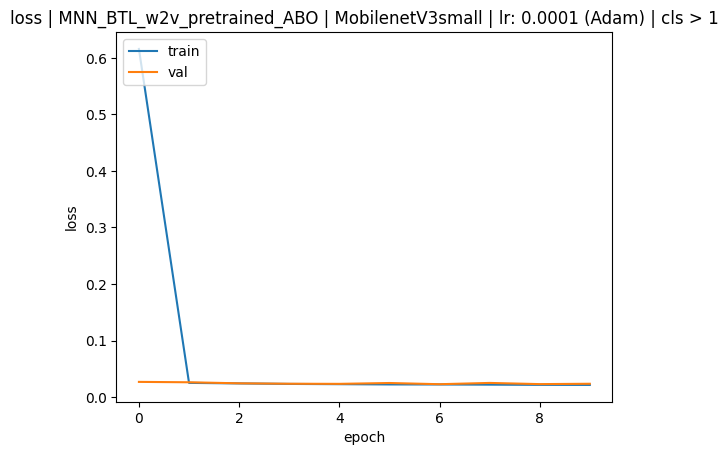

In [64]:
plot_metrics(history.history, [],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [65]:
from utils.metrics import evaluate

In [66]:
test_merged = pd.concat([test.reset_index(drop=True), test_false.reset_index(drop=True)])
img_test_merged = np.concatenate([img_test, img_test_false])
text_test_merged = np.concatenate([text_test, text_test_false])
print(test_merged.shape, img_test_merged.shape, text_test_merged.shape)

(16803, 5) (16803, 576) (16803, 300)


In [67]:
evaluate(mnn_btl.model, [img_test_merged, text_test_merged], test_merged[["label"]], log_dir, model_name,
         img_model.name, optimizer_name, learning_rate, config["data"]["cls"], triplet_model=True)

16803/16803 [==============================] - 17s 1ms/step - loss: 0.0699
